In experiment 4 we will be unfreezing top layers of EfficientNEtB0 and start training from where the experiment 3 was finished i.e. from epoch 5.

1. Importing helping functions and the data

In [21]:
from help_functions import download_and_unzip, dir_explore, create_callbacks, plot_loss_curves, view_random_image

In [2]:
url =  'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
zip_file_name = '10_food_classes_10_percent.zip'
data_folder_path = zip_file_name[:-4]

download_and_unzip(url, zip_file_name)

In [3]:
dir_explore(zip_file_name[:-4])

There are 2 directories and 0 files in 10_food_classes_10_percent folder.
There are 10 directories and 0 files in 10_food_classes_10_percent\test folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\chicken_curry folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\chicken_wings folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\fried_rice folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\grilled_salmon folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\hamburger folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\ice_cream folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\pizza folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\ramen folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\steak folder.
There are 0 directories a

2. Defining the training and testing data flow process.

In [4]:
import tensorflow as tf

batch_size=32
image_size=(222,222)

train_data_dir = data_folder_path + '/train'
test_data_dir = data_folder_path + '/test'

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, 
                                                                batch_size=batch_size, 
                                                                image_size=image_size,
                                                                label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_data_dir, 
                                                                batch_size=batch_size, 
                                                                image_size=image_size,
                                                                 label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


3. Defining data augmentation layers

In [5]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = 'data_augmentation')

4. Viewing a random image with/without data augmentation.

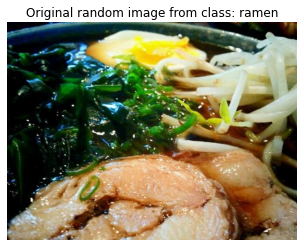

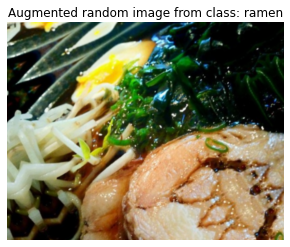

In [6]:
import matplotlib.pyplot as plt

img, target_class = view_random_image(train_data_dir)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

5. Defining the model sequence.

In [7]:
from tensorflow import keras

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

input = tf.keras.layers.Input(shape = image_size + (3,) , name="input_layer")

x = data_augmentation(input)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

output = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

model_3 = keras.Model(input, output)

6. loading model, compiling and evaluating before training.

In [8]:
import tensorflow as tf
model_3.load_weights('Models\Exp_03_Models\model_2_ep_05_val_accuracy_0.7993.ckpt')

In [11]:
from tensorflow.keras.optimizers import Adam
model_3.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model_3_evaluate_results = model_3.evaluate(test_data)
model_3_evaluate_results

79/79 [==============================] - 55s 673ms/step - loss: 0.7033 - accuracy: 0.8068


[0.703266978263855, 0.8068000078201294]

7. Marking the unfreeze layers of the base model.

In [12]:
base_model.trainable = True

for layer in model_3.layers:
  print(layer.trainable)

model_3.layers


True
True
True
True
True


In [15]:
for layer_number, layer in enumerate(base_model.layers[:-10]):
  layer.trainable = False
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [16]:
print(len(model_3.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)
print(len(base_model.trainable_variables))

10
10


8. Fitting the model

In [17]:
from tensorflow.keras.optimizers import Adam
model_3_history = model_3.fit(train_data, 
            steps_per_epoch=len(train_data), 
            initial_epoch=4,
            epochs=10,   
            validation_data=test_data, 
            validation_steps=int(0.25*len(test_data)),
            callbacks = create_callbacks(tensorboard_dir_name='TensorBoard',
                                            experiment_name= 'EfficientNet_FineTuning_Exp_04',
                                            checkpoint_path = 'Models/Exp_04_Models/model_3_ep_{epoch:02d}_val_accuracy_{val_accuracy:.04f}.ckpt',
                                            save_weights_only=True)
                                            )

Saving TensorBoard log files to: TensorBoard/EfficientNet_FineTuning_Exp_04/20211125-115315
Epoch 5/10


C:\Users\Sahil\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 36s 1s/step - loss: 0.7389 - accuracy: 0.7933 - val_loss: 0.6888 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 31s 1s/step - loss: 0.6459 - accuracy: 0.8147 - val_loss: 0.6643 - val_accuracy: 0.8092
Epoch 7/10
24/24 [==============================] - 30s 1s/step - loss: 0.6090 - accuracy: 0.8280 - val_loss: 0.5914 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 29s 1s/step - loss: 0.5552 - accuracy: 0.8480 - val_loss: 0.6127 - val_accuracy: 0.8257
Epoch 9/10
24/24 [==============================] - 31s 1s/step - loss: 0.5140 - accuracy: 0.8640 - val_loss: 0.5597 - val_accuracy: 0.8339
Epoch 10/10
24/24 [==============================] - 30s 1s/step - loss: 0.4859 - accuracy: 0.8933 - val_loss: 0.5442 - val_accuracy: 0.8322


9. Model evaluation and plotting the loss curves

In [18]:
model_3_evaluate_results_exp_04 = model_3.evaluate(test_data)

79/79 [==============================] - 53s 670ms/step - loss: 0.5457 - accuracy: 0.8284


In [19]:
model_3_evaluate_results_exp_04

[0.5456514358520508, 0.8284000158309937]

82 % is a good accuracy - Increasing the training data can help.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


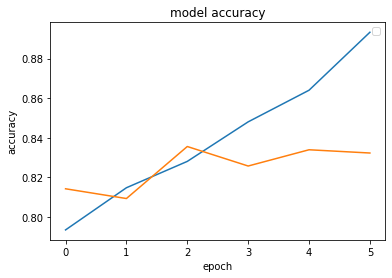

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


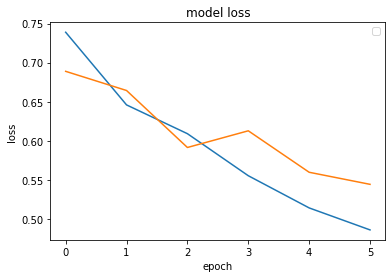

In [22]:
plot_loss_curves(model_3_history)

In [23]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 222, 222, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trainab